# Exercise 4
In this exercise, we will control a 2D drone depicted in the figure below <br>
<img src='quadrotor.png' width="300">

Consider the following simplified linear model of the drone
$$\begin{align}
    x_{n+1} = A
    x_n + B u_n
\end{align}$$

where the components of the state $x_n$ correspond to the horizontal position and velocity of the quadrotor, its vertical position and velocity and its orientation and angular velocity. The control vector
$u_n$ contains the forces produced by the rotors (our control inputs).
The module ```quadrotor.py``` defines the matrices $A$ and $B$ and code to generate a simulation of the drone.

In [1]:
## what we need to do computation and display the drone
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

import quadrotor

In [2]:
# the matrices A and B are already defined in the quadrotor module
print(f'A =\n {quadrotor.A}')
print(f'B =\n {quadrotor.B}')


A =
 [[ 1.      0.01    0.      0.      0.      0.    ]
 [ 0.      1.      0.      0.     -0.0981  0.    ]
 [ 0.      0.      1.      0.01    0.      0.    ]
 [ 0.      0.      0.      1.      0.      0.    ]
 [ 0.      0.      0.      0.      1.      0.01  ]
 [ 0.      0.      0.      0.      0.      1.    ]]
B =
 [[ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.     0.   ]
 [ 0.02   0.02 ]
 [ 0.     0.   ]
 [ 0.015 -0.015]]


We want to generate a control input will move the drone towards the point $(3,3)$ starting from $(0,0)$. In order to
do so, we define a cost that penalizes the distance to the goal at each time step while minimizing velocities and the amount of trust needed,
i.e. we want to solve the following optimal control problem
$$\begin{align}
&\min_{x_0, u_0, x_1, u_1, \cdots} \frac{1}{2}\sum_{n=0}^{N} (x_n - x_{desired})^T Q (x_n - x_{desired}) + u_n^T R u_n\\
\textrm{subject to}\ \ & x_{n+1} = A x_{n} + B u_n\\
& x_0 = [0,0,0,0,0,0]^T
\end{align}$$
where $x_{desired} = [3,0,3,0,0,0]^T$

1. Write down the KKT conditions for the problem
2. Write code to solve the problem for N=500 time steps (you will need to find diagonal matrices $Q>0$ and $R>0$ to create a nice movement) by solving the KKT system of linear equations. Do NOT inverse the KKT matrix, instead use the [NumPy solve function](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html) which is numerically more stable and efficient.
4. Show plots of all the states of the robot as a function of time
5. Show plots of the optimal control as a function of time

### Part 1
The gievn problem can be written in the form of 
$$
\min_{y} \frac{1}{2} y^T G y
$$
subject to 
$$
M y = p
$$

Now the Lagrangian can be written as 
$$
L(y, \lambda) = \frac{1}{2} y^T G y + \lambda^T (M y - p)
$$
The KKT conditons are then
$$

\nabla_x L = Gy +M^T\lambda = 0 \\
\nabla_\lambda L = My-p=0 \\
$$
Or Equivalently
$$
% \text{Or} \quad 
\begin{bmatrix}
G & M^T \\
M & 0
\end{bmatrix}
\begin{pmatrix}
y \\
\lambda
\end{pmatrix}
=
\begin{pmatrix}
0 \\
p
\end{pmatrix}
$$
where
$$
\text{Where, } G =
\begin{bmatrix}
Q & 0 & 0 & 0 & 0 & \cdots \\
0 & R & 0 & 0 & 0 & \cdots \\
0 & 0 & Q & 0 & 0 & \cdots \\
0 & 0 & 0 & R & 0 & \cdots \\
0 & 0 & 0 & 0 & 0 & \cdots
\end{bmatrix}
\quad
\newline
y =
\begin{bmatrix}
x_0 - x_{\text{desired}} \\
u_0 \\
x_1 - x_{\text{desired}} \\
u_1 \\
\vdots
\end{bmatrix}
\quad
\newline
M =
\begin{bmatrix}
I & 0 & 0 & 0 & 0 & 0 & \cdots \\
A & B & -I & 0 & 0 & 0 & \cdots \\
0 & 0 & A & B & -I & 0 & \cdots \\
0 & 0 & 0 & 0 & A & B & \cdots \\
0 & 0 & 0 & 0 & 0 & 0 & \cdots
\end{bmatrix}
\quad
\newline
p =
\begin{bmatrix}
x_0 \\
0 \\
0 \\
0 \\
\vdots
\end{bmatrix}
$$





In [3]:
# we define a few constants
xdim = 6 # dimension of the state (p,v)
udim = 2 # dimension of the control (u)
N = 500 # number of steps
nvars = N*udim + (N+2)*xdim # total number of variables
dt = 0.01 #delta t
# we define the desired coordinates
desired_coordinates = np.array([3,3])

## We define the cost
Q = np.eye(xdim)
Q[0,0] = Q[2,2] = Q[4,4] = 10.  # position penalty
Q[1,1] = Q[3,3] = Q[5,5] = 5.   # velocity penalty
R = np.eye(udim) * 0.01

# Placeholder Matrix for the cost to go
P_n = np.zeros((N, xdim, xdim))
# Since we are computing from back 
P_n[N-1] = Q
# Feedback matrix
K = np.zeros((N, udim, xdim))
# State and control inputs 
u = np.zeros((udim, N))  
x = np.zeros((xdim, N))  
# Desired State
x_desired = np.array([desired_coordinates[0], 0, desired_coordinates[1], 0, 0, 0])

# Backward pass
for i in range(N-2, 0, -1):
    K_B = R + quadrotor.B.T @ P_n[i+1] @ quadrotor.B
    K_A = quadrotor.B.T @ P_n[i+1] @ quadrotor.A
    # Solve for K_n+1
    K[i+1] = np.linalg.solve(K_B, K_A)
    # Update cost-to-go matrix
    P_n[i] = Q + quadrotor.A.T @ P_n[i+1] @ quadrotor.A - \
        quadrotor.A.T @ P_n[i+1] @ quadrotor.B @ K[i+1]

# Forward pass:
for i in range(0, N-1, 1):
    # Compute the control input
    u[:, i] = -K[i] @ (x[:, i] - x_desired)
    # Update the state of the drone
    x[:, (i+1)] = quadrotor.A @ x[:, i] + quadrotor.B @ u[:, i]


# Optionally, animate the robot's movement (this requires the quadrotor animation function)
quadrotor.animate_robot(x, u, goal=[3, 3])  

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAL+RtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
ENhliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCNT/0/deNpxANBL7R6l87LmplBSGUsMQgNinSvYBoi8EPlGhxil7rIakrntmRfU0qiM0BAfkrs+
j5GFt2itzqQrfd3lpmJFXa+MNDKxweBUJBLIU/3nnkAFuR+wSGS1R3baEJNmkJtv9QkKzPL1D8ge
RrUHH6iEMmPeZXqEU9N+wdZ3pbWsr3CmKqMPW6QAPuubbXHn7oeRPpcbdx2PEb3Pjv0LQIvWJTS6
Yshbxb/waOsmEtAuFYiPugmHD0Uc6dBSOZpxtrApYbKI8CPKIfy/TrX2bfrUpEhHQzbwirKEIlUT
NdITskVOP3ljXm345J8cPx/JrUJ1COOAsTYQkvg0Md8oYnS+vnP9lhYagjUv1VaxVIXy4l9q/R/5
lafLwxIIzF0i9izWs8BCmmZ+Q2HTLrhE5wEE9Ieu7h0yGmIARMk4L6lXc+A0XRfZy93QeM8TOoX0
p7ppihRfjW6QgF98EdsMf+XSRj/KjMIABkq5pn7XQbd2Dr6GZeH2dBGreUNAo2X7FATl8SajrJNf
68mAv3m7XsVT5VnxHN24MuRJltQU9olC7UCJbZtWLMgXmMwbstRfe3zLEkOkbDULlCrrcOdh2MvL
F41k3GynFwfYihQ0XDoRqtABBdPtgScIp9eblfVdUzuzbxQD2pjqWdCSBMYGjktlg+iDuRlw+4FG
mOKucI8zOj5K0/GI/+P5J6H4+WfRlELuEri6Kyh7PjCVn/QrH6Q2srk+jVcOwDSrQ6B+6Vw5X/Tl
yJCr2TuVC96wArMzXtGXgTwbAiotDbdeq6pJIeS9CQ4Ar7cyEP9iFyoyd6gbYkDzQ5+o7zp3kfhZ
soWQkhO1Gtu/Tqw1ud+BPSUgs+frpvTqKgVjSHX9CtcwQ+X3O/6B+wQPMuLOGV2f4el0c8UanJG0
l7GiGoRAZRysx9oLFNis5s8FbrHndkSM2ovKgQQUezCvlOh37tEkqcfk4O8AWpSCMzmcLhP307ZN
O6NrGIjElF0iohI1JjIBKp0Va+SJvR7o0b/bGpDSgmie3fi+d/fEpZbHJ+TOC0WfII+MyI2v5qF+
DCT+IV7emBtyQ543mr8gvVJbGW6xVfUBwQAAJlUmeqJLRzA7ePD3CV2SMNRikWyCGL0R+RoZPws7
E/oDdfJ8v82ncOJU/EYRWle4q0Qh7Fiqux+iBwjzve6lq/tzbGXrwa4L6qvUysbCwb4PnAJjvvZV
L5HvAxwvjgdZtSd5imcZBMQJc/ZNIzLyCdP7f8QhyRSLdghz7ECqgnkXdbxE5u1GT5BmUa7B6ozm
3xWoa1cOI7AtfHqq43kdunlBJZcnujetAPvt3h1qW2RCUU64ZwmAGdhjwFE7xowySrlUGqfF2sE0
9OVQvqZHN1vlJ5rlQhQpO5oK4SpSHQ7rW9NPo/q9yhDk5QNDkrPKhe7soYQDqONtEBJq6y8v/ChH
Leb6cMdTfdwsWAiJ5vCxmAkkgv8AHMZeMth+/V1RLiLQmgoLMtt13gF4vAt4whqfzkJJN2wSYdAb
S4CRThDPc0pu2VgiAyKxBe1Q+IqKaoo1dzmSArQAAAMAAAMAAbtLjxrpbYoSQQHt1ywxCMrFmZj6
jm6vNb2t370DlH5Eq7nOmdPy9nLKe+Q3/iN+84smWlrlCOxV7lgsa57Ww5wXSMNR6YKtwhPF9euc
FLsjYstkp8f5tqOPQfmmp2IsqnievzLpoQ3Ml5p/aohk/bWsQ6V7EKQqviwcJ9qTj64DG0R9L7xm
FWTJUtzcmGWbBi0JUNGKcuEqSViuxcwga/Kw6wqPMRQZMVdGq9nBSRDD+bv00sk+TyL7x3WSYOPD
5GCa6qD/9cFZjjRROHZHgd4lE1UIaFnDLSdSz2BZfGpp07vgzbyUXOhymYX8bWxlzfmt0A7ZaOI1
4alhB25h9KoU6IYfQ6x72J8EZYAABuTg5tSEk0WrpHAIMvxE14fFRTeY8ibeZn2NQdqsRXPx9Zjb
p416IDTCj7PVuSN8J9ttyurZ2AfMHDGTgXbb1TlReN8f5c7a0QvBeYzbDY9eUGJ67VEctbbPTKCV
CPL+dDN8hoOc+wb4KSlP8niGRZ6K1L98qRrhZv0wwHz5Bn9M7osfQ43gjEQl1wzrFgYrIffBHPyw
CWCWgy60fLdP0nm3xVUwv6rJIzfxGnVJqXT/j781/zY2AU3Kc+uCySK21MzVxgVXETrsPw3y89pP
jBiiRj5PAZL/9r//b2lIqWf50MO1VxYfYyypeDN5kUjAX87lyheikgAT+XYBSl87zIs0SE6Gy1iz
LIIeldyVXc+c0N/ohOKHdXzoS7rETBPEbmlcjBkSQn4vd7ua65Z1U6/u6Km5e8hBoRTbYgMgCYLi
9EcyyLnb6gTHpfgpe4qKbIR1Q7nEHtyDcU6nqT4bLdnvTwOKRr8GRrd+cmxZ2XxVV4LTHVsuscsk
p1FQ4HnvFB2Sf4t7iGMg4Vqqpp0pIbhaDga7MtJFThg7uSp+YET50ECnQcZVfpCW7fduRI24CqW+
Ke9MeA2xP19IGuoEKcBGeeWKKD78JsU/rz3TJfUe5kmOKtccQTWOlpXeNMWXEM5yPDRbzsCyxWvU
35kLglp8Hvm2vqZ+pYsT37f8d7FsIk0dwtBcD+IOrFa6g+mz50aNfrVR3m2xwCUzOyjjplN5kOvC
fzhdiS4WxsoUKN9/GGTBaKSXFeg69qQJBW0z6AjkMUTFMtnnS5wQQreL3YDasQfjejPPn11z1MTQ
3uHVxdBgAB3AAABIY5JKeA9gy6NBD/ix6LPMpodpV++rGbbn66fzfnPTHFZ1YCFx7dp7cHqfOt/I
ffNnmv0eMWthf/zI0WmDE

Text(0.5, 0, 'Time')

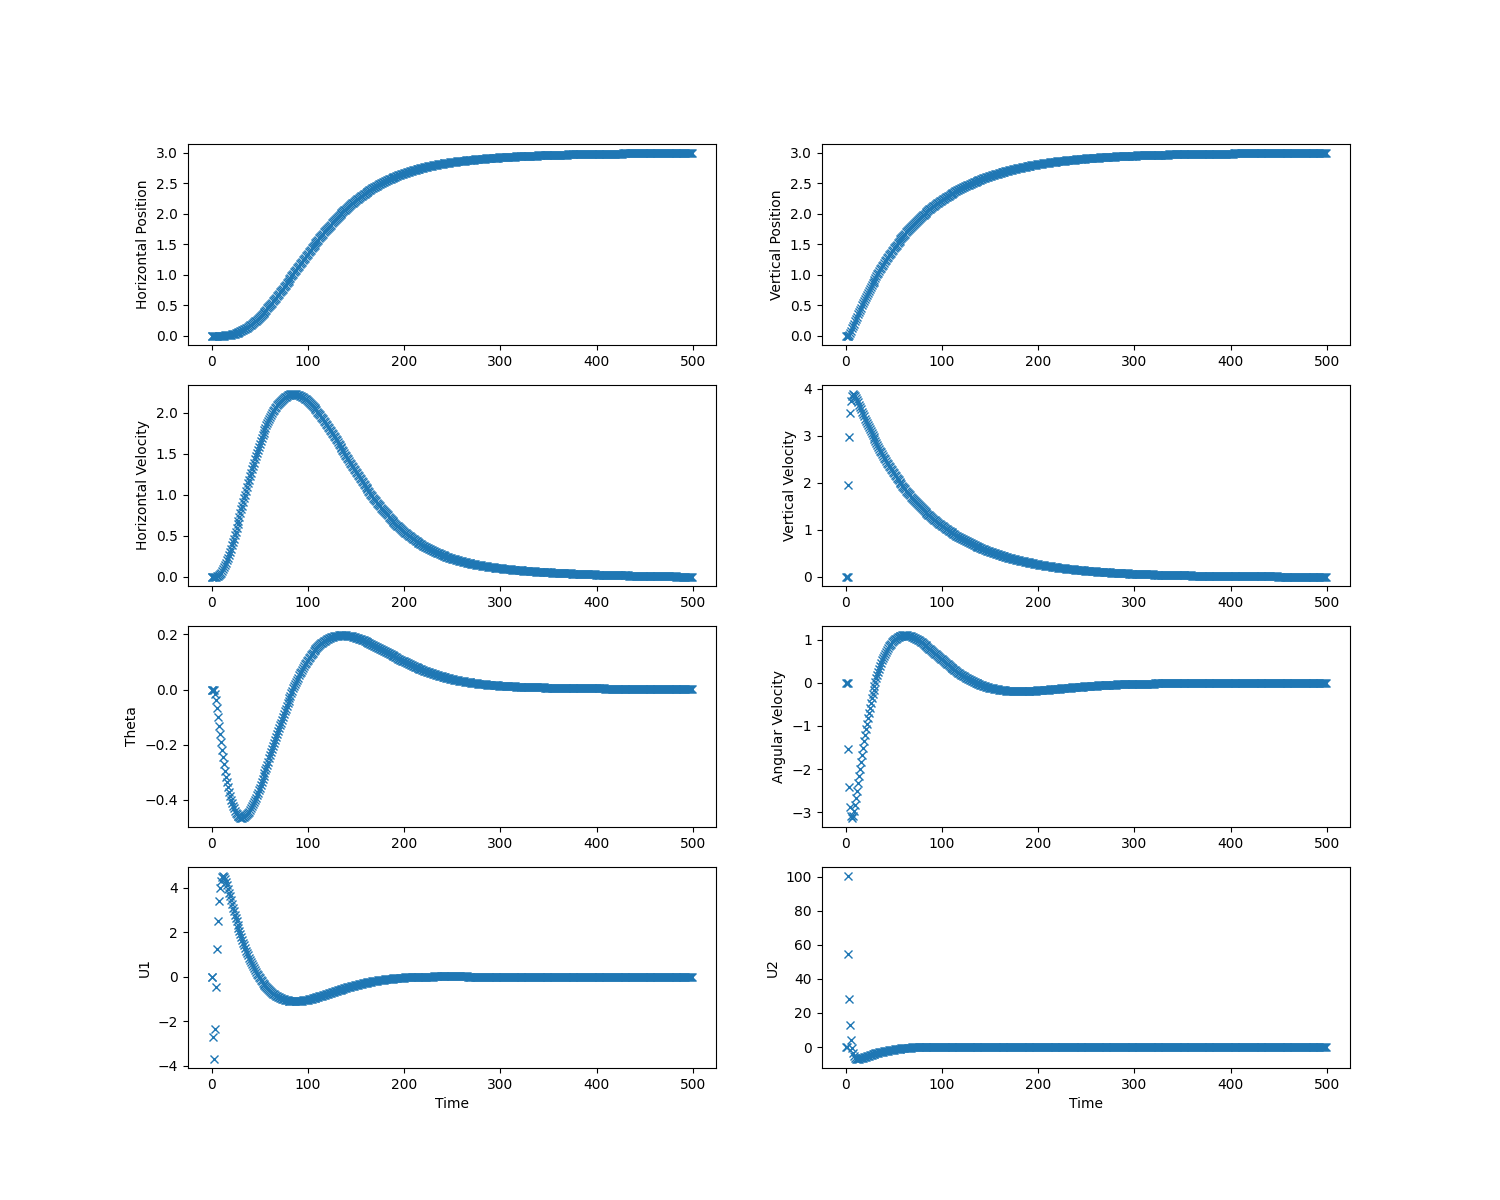

In [5]:
# Plot the state and control inputs
plt.figure(figsize=[15, 12])
plt.subplot(4,2,1)
plt.ylabel('Horizontal Position')
plt.plot(x[0,:], 'x')
plt.subplot(4,2,2)
plt.ylabel('Vertical Position')
plt.plot(x[2,:], 'x')
plt.subplot(4,2,3)
plt.plot(x[1,:], 'x')
plt.ylabel('Horizontal Velocity')
plt.subplot(4,2,4)
plt.plot(x[3,:], 'x')
plt.ylabel('Vertical Velocity')
plt.subplot(4,2,5)
plt.plot(x[4,:], 'x')
plt.ylabel('Theta')
# plt.xlabel('Time')
plt.subplot(4,2,6)
plt.plot(x[5,:], 'x')
plt.ylabel('Angular Velocity')
# plt.xlabel('Time')
plt.subplot(4,2,7)
plt.plot(u[0,:], 'x')
plt.ylabel('U1')
plt.xlabel('Time')
plt.subplot(4,2,8)
plt.plot(u[1,:], 'x')
plt.ylabel('U2')
plt.xlabel('Time')
